In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
category_lines['Italian'][0:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8962, -2.9009, -2.9051, -2.9649, -2.8432, -2.8375, -2.7838, -2.8465,
         -2.9419, -2.7760, -2.9343, -2.9386, -2.9524, -2.9173, -2.9206, -2.9080,
         -2.8828, -2.9020]], grad_fn=<LogSoftmaxBackward>)


In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 9)


In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(2):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    print(category_tensor)
    print(line_tensor)

category = Portuguese / line = Castro
tensor([13])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [11]:
criterion = nn.NLLLoss()

In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [13]:
import time
import math
import pprint

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        pprint.pprint("=====category_tensor======")
        pprint.pprint(category_tensor)
        pprint.pprint("=====output======")
        pprint.pprint(output)
        pprint.pprint("=====loss======")
        pprint.pprint(loss)
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

'=====category_tensor======'
tensor([17])
'=====output======'
tensor([[-2.8092, -2.9627, -2.8646, -3.2150, -2.8359, -3.1485, -2.9226, -2.8344,
         -2.7069, -3.0651, -3.0175, -2.7669, -3.1568, -2.9117, -2.4855, -2.8045,
         -2.8345, -2.9547]], grad_fn=<LogSoftmaxBackward>)
'=====loss======'
2.9546990394592285
5000 5% (0m 12s) 2.9547 Sobol / Scottish ✗ (Polish)
'=====category_tensor======'
tensor([13])
'=====output======'
tensor([[-2.9147, -3.4157, -2.8544, -1.7780, -5.0417, -4.6575, -3.0901, -3.1524,
         -2.8451, -3.1587, -2.6073, -3.6418, -2.3736, -1.8326, -3.1521, -3.3998,
         -4.7224, -3.1364]], grad_fn=<LogSoftmaxBackward>)
'=====loss======'
1.832608699798584
10000 10% (0m 24s) 1.8326 Machado / Japanese ✗ (Portuguese)
'=====category_tensor======'
tensor([15])
'=====output======'
tensor([[-2.7894, -2.6140, -2.0051, -2.4560, -4.1638, -3.6683, -3.7387, -2.5922,
         -2.5270, -2.3309, -2.7375, -4.7868, -2.8099, -2.6596, -3.1507, -3.2199,
         -4.2675, -3.5749

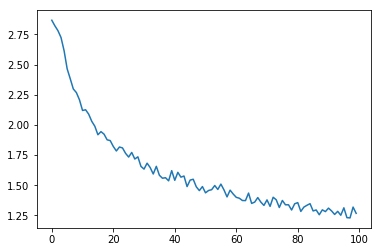

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


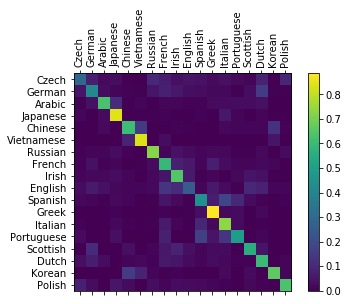

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Luong')
predict('Kafka')
predict('Muyskens')


> Dovesky
(-0.09) Russian
(-3.61) Czech
(-3.79) English

> Jackson
(-0.87) Scottish
(-1.06) English
(-2.66) Russian

> Satoshi
(-0.95) Japanese
(-1.19) Italian
(-2.53) Arabic

> Luong
(-0.39) Vietnamese
(-2.52) German
(-3.01) Italian

> Kafka
(-0.99) Japanese
(-1.14) Czech
(-1.34) Polish

> Muyskens
(-0.37) Dutch
(-2.16) German
(-2.53) English


In [17]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [18]:
torch.save(rnn,'model/rnn.pickle')

/Users/hyundai/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [19]:
rnn.state_dict()

OrderedDict([('i2h.weight',
              tensor([[-0.2057, -0.1287,  0.1036,  ...,  0.0653, -0.0549,  0.1070],
                      [ 0.1995, -0.0265, -0.0051,  ..., -0.0102,  0.0277, -0.0607],
                      [ 0.0288, -0.2054, -0.0105,  ..., -0.0131, -0.1042, -0.0492],
                      ...,
                      [-0.0529, -0.0846, -0.0458,  ...,  0.0023, -0.0427, -0.0583],
                      [ 0.1903,  0.1741,  0.2179,  ...,  0.0598, -0.1981, -0.0768],
                      [-0.1869, -0.2382, -0.0106,  ...,  0.1010,  0.0127,  0.0737]])),
             ('i2h.bias',
              tensor([ 0.0427, -0.0421, -0.0186, -0.1332, -0.0899, -0.0443,  0.0885,  0.0149,
                       0.0309, -0.0407,  0.1000,  0.0126, -0.0012, -0.0033, -0.1386,  0.1038,
                      -0.0530, -0.0303, -0.0121,  0.0535,  0.0451,  0.0216, -0.0390, -0.0524,
                      -0.0562, -0.0341,  0.1087, -0.1413, -0.1140, -0.0272, -0.0377,  0.0895,
                      -0.0120, -0.04

In [20]:
rnn2 = torch.load('model/rnn.pickle')

In [21]:
rnn2.state_dict()

OrderedDict([('i2h.weight',
              tensor([[-0.2057, -0.1287,  0.1036,  ...,  0.0653, -0.0549,  0.1070],
                      [ 0.1995, -0.0265, -0.0051,  ..., -0.0102,  0.0277, -0.0607],
                      [ 0.0288, -0.2054, -0.0105,  ..., -0.0131, -0.1042, -0.0492],
                      ...,
                      [-0.0529, -0.0846, -0.0458,  ...,  0.0023, -0.0427, -0.0583],
                      [ 0.1903,  0.1741,  0.2179,  ...,  0.0598, -0.1981, -0.0768],
                      [-0.1869, -0.2382, -0.0106,  ...,  0.1010,  0.0127,  0.0737]])),
             ('i2h.bias',
              tensor([ 0.0427, -0.0421, -0.0186, -0.1332, -0.0899, -0.0443,  0.0885,  0.0149,
                       0.0309, -0.0407,  0.1000,  0.0126, -0.0012, -0.0033, -0.1386,  0.1038,
                      -0.0530, -0.0303, -0.0121,  0.0535,  0.0451,  0.0216, -0.0390, -0.0524,
                      -0.0562, -0.0341,  0.1087, -0.1413, -0.1140, -0.0272, -0.0377,  0.0895,
                      -0.0120, -0.04

In [22]:
def evaluate2(line_tensor):
    hidden = rnn2.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn2(line_tensor[i], hidden)

    return output

def predict2(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate2(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.09) Russian
(-3.61) Czech
(-3.79) English

> Jackson
(-0.87) Scottish
(-1.06) English
(-2.66) Russian

> Satoshi
(-0.95) Japanese
(-1.19) Italian
(-2.53) Arabic
